In [1]:
import librosa
import numpy as np
import pandas as pd
import os
import sys
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ls

BDLib/                hd_model.c            main.dSYM/
BDLib1_reduced.ipynb  hd_model.h            old_hd_model/
cJSON.c               hypervector.json      projection.json
cJSON.h               hypervector.txt       projection.txt
classEncoding.txt     label.json            random.ipynb
data.json             main*
dataNew.json          main.c


In [42]:
count = 0
all_data = []
all_label = []
for subdir, dirs, files in os.walk("BDLib"):
    for file in files:
        filepath = os.path.join(subdir, file)
        if file.endswith('.DS_Store'):
            continue  # Skip this file
        # print(filepath)
        if 'airplane' in filepath:
            label = 0
        if 'alarms' in filepath:
            label = 1
        if 'applause' in filepath:
            label = 2
        if 'birds' in filepath:
            label = 3
        if 'dogs' in filepath:
            label = 4
        if 'footsteps' in filepath:
            label = 5
        if 'motorcycles' in filepath:
            label = 6
        if 'rain' in filepath:
            label = 7
        if 'rivers' in filepath:
            label = 8
        if 'seawaves' in filepath:
            label = 9
        if 'thunderstorm' in filepath:
            label = 10
        if 'wind' in filepath:
            label = 11
            
        wav, sr = librosa.load(filepath, sr=44100)
        step_num = int((44100 * 1) / 2)
        
        ind = 0
        while ind + step_num + step_num <= wav.shape[0]:
            frame = wav[ind:ind+step_num+step_num]
            ind = ind + step_num
            count = count + 1
            hop_length = 44100 // 100
            
            melspec = librosa.feature.melspectrogram(y=frame, sr=44100, hop_length=hop_length)
            melspec = librosa.power_to_db(melspec, ref=np.max)
            m1 = np.mean(melspec,axis = 1)
            m2 = np.std(melspec,axis = 1)
            
            feature_list = [m1,m2]
            features = np.concatenate([feature.flatten() for feature in feature_list])
            
            all_data.append(features)
            all_label.append(label)
        
print(count)

2280


In [43]:
len(all_data)

2280

In [44]:
len(all_label)

2280

In [45]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.3, random_state=42)

In [46]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
clf.fit(X_train, y_train)
sum(clf.predict(X_test) == y_test) / len(y_test)

0.9839181286549707

In [ ]:
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################

In [48]:
class linear_random_projection:
    def __init__(self,in_dim,out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.init_projection()

    def init_projection(self):
        self.projection = np.random.normal(0, 1, size=(self.out_dim, self.in_dim))
        self.projection = np.sign(self.projection)

    def encode(self,x):
        enc = self.projection @ x
        enc = enc.squeeze()
        return np.sign(enc)

In [49]:
class hd_model:
    def __init__(self,X_train, X_test, y_train, y_test ,in_dim,out_dim,lr):
        
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        self.X_train = scaler.transform(X_train)
        self.X_test = scaler.transform(X_test)
        self.y_train = y_train
        self.y_test = y_test
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.lr = lr

        self.encoder = linear_random_projection(self.in_dim,self.out_dim)
        self.class_hvs = np.zeros((12,self.out_dim))
        
        self.train_encs = []
    
    def train_(self):
        n_train = len(self.X_train)
        for i in range(n_train):
            sample = self.X_train[i]
            label = self.y_train[i]
            enc = self.encoder.encode(sample)
            similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
            pred = np.argmax(similarities)
            self.class_hvs[label] +=  enc
            self.class_hvs[pred] -= enc
            self.train_encs.append(enc)

    
    def test_(self):
        preds = []
                           
        n_test = len(self.X_test)
        for i in range(n_test):
            sample = self.X_test[i]
            label = self.y_test[i]
            enc = self.encoder.encode(sample)
            similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
            pred = np.argmax(similarities)
            preds.append(pred)
        
        print("================================")
        print(accuracy_score(self.y_test, preds))
        print(f1_score(self.y_test, preds, average="weighted"))
        cm = confusion_matrix(self.y_test, preds,labels=[0,1,2,3,4,5,6,7,8,9,10,11])
        print(cm)
        sns.heatmap(cm, annot=True)
        print("================================")




    def retrain(self):
        for e in range(3):
            count = 0
            print(e)
            for i in range(len(self.train_encs)):
                enc = self.train_encs[i]
                label = self.y_train[i]
                similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
                pred = np.argmax(similarities)
                if pred != label:
                    self.class_hvs[label] += enc
                    self.class_hvs[pred] -= enc
                    count += 1
            print(count)

In [50]:
X_train[0].shape

(256,)

0.8961988304093568
0.8952004367068395
[[34  0  0  0  0  0  3  0  0  0  0  8]
 [ 0 49  0  0  0  1  0  0  0  0  0  0]
 [ 0  0 61  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 57  0  0  0  0  0  0  0  1]
 [ 0  0  0  0 50  3  0  0  0  2  0  0]
 [ 0  0  0  0  0 60  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 51  0  0  1  0  1]
 [ 0  0  3  0  0  0  0 55 10  1  0  2]
 [ 0  0  0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0  0 13 32  0 10]
 [ 1  0  0  0  0  0  0  0  0  1 65  0]
 [ 4  0  0  1  3  0  0  0  0  0  2 46]]


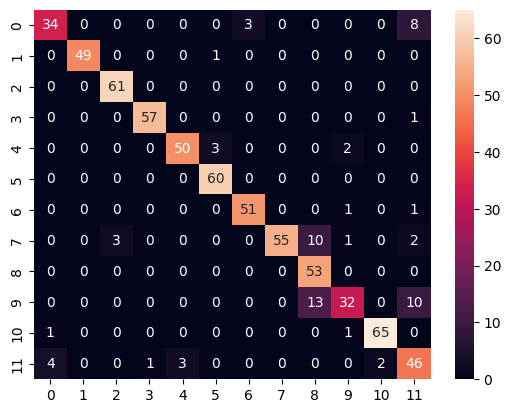

In [56]:
model = hd_model(X_train, X_test, y_train, y_test,256,10000,1)
model.train_()
model.test_()

0
128
1
47
2
45
0.9605263157894737
0.960489392369688
[[44  0  0  0  0  0  0  0  0  0  1  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 60  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 58  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 49  4  0  0  0  0  1  1]
 [ 0  0  0  3  0 57  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  1  0  0]
 [ 0  0  0  0  0  0  0 68  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 52  0  2]
 [ 1  0  0  0  0  1  0  0  0  0 65  0]
 [ 4  0  0  1  2  0  0  0  0  0  0 49]]


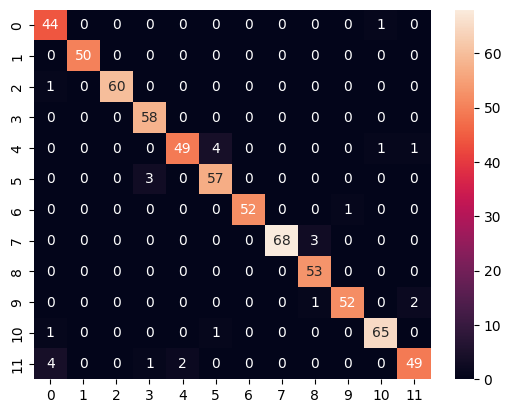

In [57]:
model.retrain()
model.test_()

In [53]:
model.class_hvs

array([[  7.,  -1.,   9., ...,  -5.,  -1., -19.],
       [ 12.,   0.,  -6., ...,   2., -12.,  -2.],
       [ 20.,  -6.,  10., ...,  -6.,  -4.,   2.],
       ...,
       [ -2.,   2.,   2., ...,   6.,   8.,  -8.],
       [ -6.,   6.,  -2., ...,   2.,  -2.,  -4.],
       [-11.,   3.,   7., ...,  -1.,  15.,  19.]])